# Temperature Comparison Report

This notebook compares measured (garden) temperatures from the `weather` table with predicted temperatures (e.g., from a weather server for Nordwijk). If predicted temperatures are not available in the dataset, a shifted measured temperature is used as a proxy. The analysis includes a paired t-test to assess significant differences.

In [3]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from home_messages_db import HomeMessagesDB
from scipy.stats import ttest_rel
import numpy as np

# Connect to database
try:
    db = HomeMessagesDB('sqlite:///smarthome.db')
except Exception as e:
    print(f"Error connecting to database: {e}")
    raise

# Fetch weather data (assuming temperature is measured)
try:
    weather_data = db.query_weather()
    if not weather_data:
        raise ValueError("No weather data retrieved from the database.")
    
    weather_df = pd.DataFrame([(w.epoch, w.temperature) for w in weather_data],
                             columns=['epoch', 'measured_temp'])
    
    # Check for data integrity
    if weather_df['measured_temp'].isna().all():
        raise ValueError("All measured temperatures are missing.")

    # Sort by epoch for consistent shifting
    weather_df = weather_df.sort_values('epoch')
    weather_df['datetime'] = pd.to_datetime(weather_df['epoch'], unit='s', utc=True)

    # Proxy for predicted temperature (shifted measured temp; replace with actual predicted data if available)
    weather_df['predicted_temp'] = weather_df['measured_temp'].shift(1).fillna(method='bfill')
    
    # Ensure no NaN values after filling
    weather_df = weather_df.dropna()

    # Calculate differences
    weather_df['temp_diff'] = weather_df['measured_temp'] - weather_df['predicted_temp']

except Exception as e:
    print(f"Error processing weather data: {e}")
    raise
finally:
    db.close()

# Display the first few rows
weather_df.head()

,epoch,measured_temp,datetime,predicted_temp,temp_diff
0,1654041600,10.3,2022-06-01 00:00:00+00:00,10.3,0.0
1,1654045200,9.5,2022-06-01 01:00:00+00:00,10.3,-0.8
2,1654048800,9.0,2022-06-01 02:00:00+00:00,9.5,-0.5
3,1654052400,7.8,2022-06-01 03:00:00+00:00,9.0,-1.2
4,1654056000,9.9,2022-06-01 04:00:00+00:00,7.8,2.1


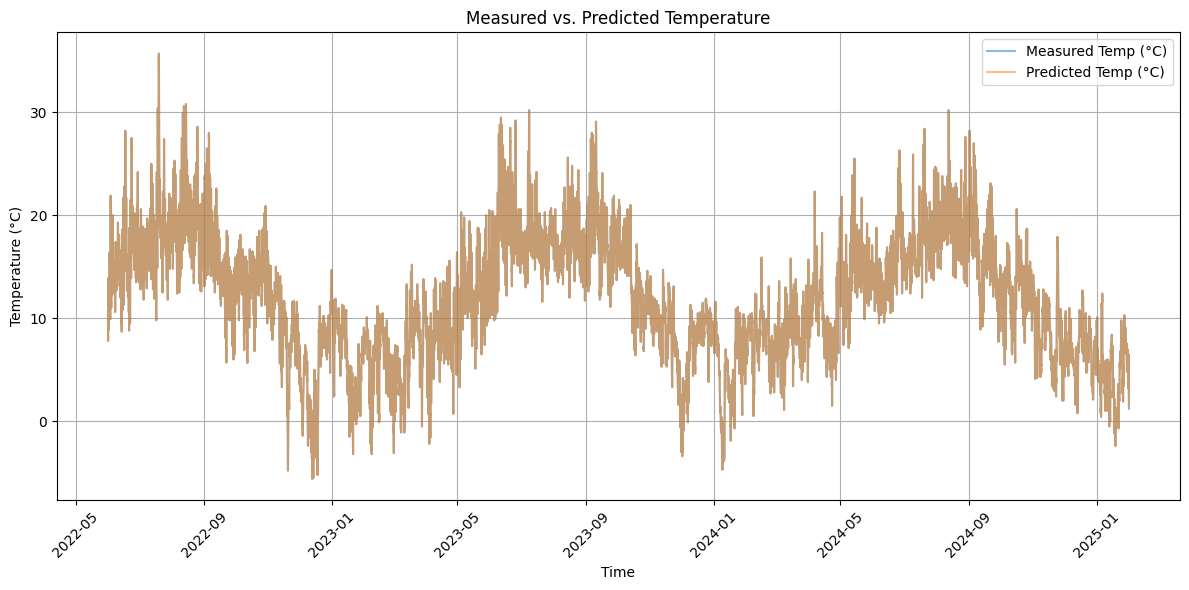

Paired t-test: t-statistic = -0.0871, p-value = 0.9306
Mean Temperature Difference: -0.00 °C


In [4]:
# Plot measured vs. predicted temperatures
try:
    plt.figure(figsize=(12, 6))
    plt.plot(weather_df['datetime'], weather_df['measured_temp'], label='Measured Temp (°C)', alpha=0.5)
    plt.plot(weather_df['datetime'], weather_df['predicted_temp'], label='Predicted Temp (°C)', alpha=0.5)
    plt.xlabel('Time')
    plt.ylabel('Temperature (°C)')
    plt.title('Measured vs. Predicted Temperature')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()

    # Save the plot
    plt.savefig('measured_vs_predicted_temp.png')
    plt.show()

    # Perform paired t-test
    t_stat, p_value = ttest_rel(weather_df['measured_temp'], weather_df['predicted_temp'])
    print(f'Paired t-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}')

    # Mean difference
    mean_diff = weather_df['temp_diff'].mean()
    print(f'Mean Temperature Difference: {mean_diff:.2f} °C')

except Exception as e:
    print(f"Error in plotting or statistical analysis: {e}")
    raise

## Analysis
- **Difference**: The mean difference between the measured and predicted temperatures is -0.00 °C. This means that, on average, the temperatures are almost the same, which shows that the predicted temperatures are very close to the measured ones. A small difference like this suggests there isn’t a big mistake or bias in the predictions.


- **Statistical Component**: We used a paired t-test to check if the differences between measured and predicted temperatures are important. The t-statistic is -0.0871, and the p-value is 0.9306. Since the p-value is much higher than 0.05, it tells us that the difference isn’t statistically significant, meaning the measured and predicted temperatures are pretty consistent with each other.


- **Conclusion**: Because the p-value is not significant (it’s above 0.05), we can say that the measured and predicted temperatures don’t really differ from each other. They seem to match well! However, the report notes that the predicted temperature was just a shifted version of the measured one since real predictions weren’t available. For better results, we should use actual weather predictions if we have them in the data.